# Problem: Microscopy

<hr>

Simulate growth in a microfluidic device and use this simulated data to train a deep-learning-based cell segmenting framework.

## We start with generating data

For that purpose check out the Python package [`SyMBac`](https://symbac.readthedocs.io/en/latest/) (Synthetic Micrographs of Bacteria). This is a great for our problem: it allows one to simulate microscopy data. This is useful for obtaining educational data that we can play with, but also can be great for segmenting your microscopy data.
Often, you may have few training data available, in particular if you have to manually define the ground truth.
Sometimes you may be lucky to fund a pre-trained model that greatly helps in boosting the initial training, but this is not always the case. For example, if you defined your own NN architecture, there are no pre-trained models.

Here, training on simulated data is what can give you the initial boost, so that fine-tuning with only a few final images from your dataset does the job.

`SyMBac` provides different growth scenarios it can simulate:
- Growth on plates
- Growth within a so-called mother machine, that is a commonly used microfluidic device that allows one to follow the lineage of dedicated mother cells.

Let's get started and follow along the tutorial https://symbac.readthedocs.io/en/latest/examples/simple_mother_machine.html

We are going to load the simulation part of the library and the usual `pyplot` to show the generated images and masks.
Following good practice, we make sure units are attached to all physical quantities.

In [2]:
# %pip install symbac

import matplotlib.pyplot as plt
from pint import UnitRegistry
import os

from SyMBac.simulation import Simulation

u = UnitRegistry()

We need to fix 2 problems in the library, first. Please change them in the `venv` directly for the moment, both are within the venv in `SYMBac/cell_simulation.py`.
On our setup that would be in `../venv/lib/python3.12/site-packages/SyMBac/cell_simulation.py`, but you need to check where this is for you. For example, you can simply search for `cell_simulation.py`.

In the file make the following fixes. The first is the complete function, while the second one is just part of the code that is changed.

```python
def wipe_space(space):
    """
    Deletes all cells in the simulation pymunk space.

    :param pymunk.Space space:
    """
    # HACK
    remove_bodies = []
    remove_shapes = []
    for body, poly in zip(space.bodies, space.shapes):
        if body.body_type == 0:
            remove_bodies.append(body)
            remove_shapes.append(poly)
    for body in remove_bodies:
        space.remove(body)
    for shape in remove_shapes:
        space.remove(shape)
```

as well as

```python
def step_and_update(dt, cells, space, phys_iters, ylim, cell_timeseries,x,sim_length,save_dir):

    ...

    # HACK
    to_remove = [shape for shape in space.shapes if shape.body.position.y < 0 or shape.body.position.y > ylim]
    for shape in to_remove:
        space.remove(shape.body, shape)
        space.step(dt)

    to_remove = []
    for cell in cells:
        if cell.shape.body.position.y < 0 or cell.shape.body.position.y > ylim:
            to_remove.append(cell)
        elif norm.rvs() <= norm.ppf(cell.lysis_p) and len(cells) > 1:   # in case all cells disappear
            to_remove.append(cell)
    
    for cell in to_remove:
        cells.remove(cell)
        space.step(dt)
    # HACK END

    ...
```

Let's define an *E. coli*-like setting.

We also need to define a camera parameter. In the lab we are using a Rasberry Pi camera. By checking its datasheet, we find that a pixel has size 1.4 um x 1.4 um.
Since we are assuming we have a 100x setup, a pixel will show 1.4 um / 100 = 0.014 um.

In [3]:
# E. coli dimensions
e_coli_length = 3.0 * u.um
e_coli_width = 1.0 * u.um

# Mother machine parameters
trench_length = 8 * u.um
trench_width = 1.1 * u.um

# Simulation parameters
nr_of_frames: int = 70
gravity_force = 0 * u.um / u.s**2
pixel_size_in_image = 0.014 * u.um

# Create output directory
os.makedirs("tmp_data", exist_ok=True)

# Setup simulation
simulation = Simulation(
    trench_length=trench_length.to(u.um).magnitude,
    trench_width=trench_width.to(u.um).magnitude,
    cell_max_length=e_coli_length.to(u.um).magnitude,
    cell_width=e_coli_width.to(u.um).magnitude,
    sim_length = nr_of_frames,
    pix_mic_conv = pixel_size_in_image.to(u.um).magnitude,
    gravity=gravity_force.to(u.um / u.s**2).magnitude,
    phys_iters=10,  # you may need to change this to stabilize
    max_length_var = 0.,
    width_var = 0.,
    lysis_p = 0.,
    save_dir="tmp_data",
    resize_amount = 3,  # recommended by library
)
simulation.offset = 120  # you may need to change this on an error

In [4]:
simulation.run_simulation(show_window=False)

  0%|          | 0/72 [00:00<?, ?it/s]

In [5]:
simulation.draw_simulation_OPL(do_transformation=True, label_masks=True)

Timeseries Properties:   0%|          | 0/70 [00:00<?, ?it/s]

Scene Draw::   0%|          | 0/70 [00:00<?, ?it/s]

In [6]:
def plot_frame(frame_nr: int) -> None:
    global simulation
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(1.5,5))
    ax1.imshow(simulation.OPL_scenes[frame_nr], cmap="Greys_r")
    ax1.axis("off")
    ax2.imshow(simulation.masks[frame_nr], cmap="jet")
    ax2.axis("off")
    plt.tight_layout()

We are now ready to see the last rendered frame.

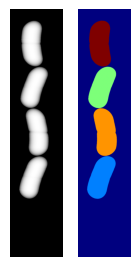

In [7]:
plot_frame(-1)

Let's see this as a video by composing all the frames. We will be using `animation` from `matplotlib` and `ffmpeg` in the background to create the final video.

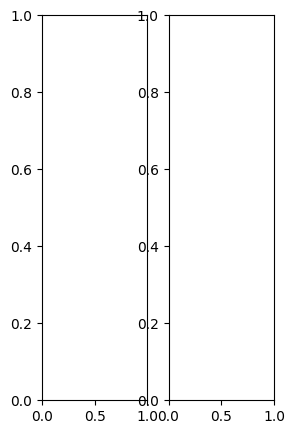

In [8]:
# Make a video from the saved data using matplotlib.animation
import matplotlib.animation as animation

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3,5))
def update(frame: int) -> None:
    ax1.clear()
    ax2.clear()
    ax1.imshow(simulation.OPL_scenes[frame], cmap="Greys_r")
    ax1.axis("off")
    ax2.imshow(simulation.masks[frame], cmap="jet")
    ax2.axis("off")
    plt.tight_layout()

# Change if you want to generate the video
if False:
    ani = animation.FuncAnimation(fig, update, frames=nr_of_frames, repeat=False)
    ani.save("simulation_video.mp4", writer="ffmpeg", fps=5)
    plt.close()

    # Show the video in the notebook
    from IPython.display import Video
    Video("simulation_video.mp4")

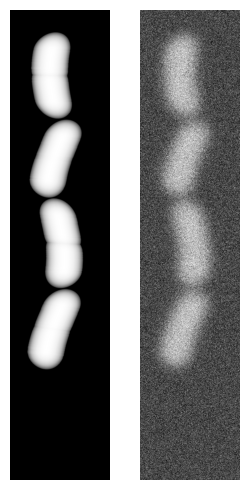

In [41]:
# Add microscope noise to the simulated images
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.util import random_noise

def add_microscope_noise(image, noise_type='gaussian', var=0.1, gaussian_sigma=10.5):
    """
    Add microscope-like noise to an image.
    
    Parameters:
    - image: input image (2D array)
    - noise_type: type of noise ('gaussian', 'poisson', 's&p' for salt & pepper)
    - var: variance for gaussian noise (default 0.01)
    - gaussian_sigma: sigma for Gaussian blur to simulate optics (default 0.5)
    
    Returns:
    - noisy_image: image with added noise and blur
    """
    # Normalize image to [0, 1]
    img_normalized = image.astype(float)
    if img_normalized.max() > 1.0:
        img_normalized = img_normalized / img_normalized.max()
    
    # Gaussian blur to simulate optical blur from microscope
    img_blurred = gaussian_filter(img_normalized, sigma=gaussian_sigma)
    
    # Add noise pixel-noise
    if noise_type == 'gaussian':
        img_noisy = random_noise(img_blurred, mode='gaussian', var=var)
    elif noise_type == 'poisson':
        # Poisson noise (photon shot noise - realistic for microscopy)
        img_noisy = random_noise(img_blurred, mode='poisson')
    else:
        img_noisy = img_blurred
    
    # Convert back to original range
    img_noisy = (img_noisy * 255).astype(np.uint8)
    
    return img_noisy


# Apply noise to a frame
frame_idx = -1  # Last frame
original_image = simulation.OPL_scenes[frame_idx]

# Create different noise versions
noisy_gaussian = add_microscope_noise(original_image, noise_type='gaussian', var=0.5, gaussian_sigma=30)

# Visualize original vs noisy images
fig, axes = plt.subplots(1, 2, figsize=(3, 5))

axes[0].imshow(original_image, cmap='Greys_r')
axes[0].axis('off')
axes[1].imshow(noisy_gaussian, cmap='Greys_r')
axes[1].axis('off')

plt.tight_layout()
plt.show()

Finally, write the noisy images and the real-masks into a `train/` directory.

In [42]:
# Your code here :)

## Preparing Data for the Cell Segmenter

You can check out the tutorial at https://symbac.readthedocs.io/en/latest/examples/omnipose_training_data_generator.html#Training-Omnipose

## Training the Cell Segmenter

The tutorial https://symbac.readthedocs.io/en/latest/examples/seg_with_omnipose.html is for the mother-machine.

---
**License**: © 2025 Matthias Függer and Thomas Nowak. Licensed under [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/).